In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pims import ImageSequence

from lib import luminance
from lib import load

### Video Material

Image data was published as datas set at the [VHub](https://vhub.org) platform. Videos of each run are published as separate dataset.
  - `pr06`: https://vhub.org/resources/4211
  - `pr05`: https://vhub.org/resources/4237
  - `ir16`: https://vhub.org/resources/4240
  - `ir15`: https://vhub.org/resources/4246
  - `ir14`: https://vhub.org/resources/4261
  - `ir13`: https://vhub.org/resources/4270
  - `ir12`: https://vhub.org/resources/4279
  - `ir07`: https://vhub.org/resources/4289
  - `ir06`: https://vhub.org/resources/4293
  - `ir05`: https://vhub.org/resources/4299
  - `ir04`: https://vhub.org/resources/4306
  - `ir03`: https://vhub.org/resources/4313

`load.show()` lists the videos that were already analyzed. `load.show(url=True)` will also print the corresponding download urls of each video.

In [43]:
load.show()

run   cam   
---   ---   
pr06  casio-f1  
pr06  rx100v  
pr06  pco  
pr05  sony-4k2  
ir16  casio-f1  
ir15  casio-f1  
ir14  casio-f1  
ir13  casio-f1  
ir12  casio-f1  
ir07  sony-4k1  
ir07  sony-4k2  
ir06  casio-f1  
ir05  casio-f1  
ir04  casio-f1  
ir03  casio-f1  



### Create an image sequence from the video file

To ease the download/file naming process, the `load.imseq()` function will test if the video data of a specific experiment (`run`) and camera (`cam`) is already present on the system (i.e. in the `data/` folder). If that is not the case, it will download the video file from VHub, and convert it to an image sequence.

In [3]:
seq = load.imgseq(run='pr06', cam='casio-f1')

Converting 'pr06_casio-f1.mp4' to image sequence


Frame([[ 84, 107, 133, ...,  80,  96,  95],
       [ 91, 113, 106, ...,  56,  61,  66],
       [118, 111,  82, ...,  70,  65,  70],
       ...,
       [109, 108, 139, ...,   4,  11,  25],
       [117,  96,  78, ...,   0,  15,  38],
       [118, 100,  71, ...,   0,  13,  35]], dtype=uint8)
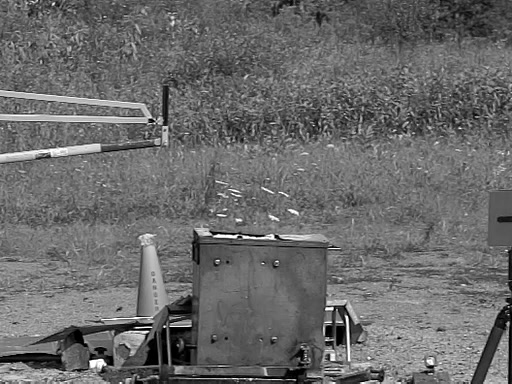

In [4]:
seq[0]

**spatial resolution:**  
Width of container top is 51 cm in real space, 129 px on image frame.

In [5]:
res = .51 / 129

**Melt brightness:**  
That should be measured from a typical melt 'domain' that shows no sign of motion blur. The measurement tool of ImageJ is the quickes way to do that.

In [6]:
bmelt = 175.

**Field of view:**  
Visible area is the images resolution multiplied by the images width $W$ and height $H$
$$
S_c = a^2\,W\,H
$$

In [7]:
H, W = seq[0].shape
Sc = res ** 2 * W * H
Sc

3.0729968631692817

Cumulative melt brightness is the brightness that would be measures if only melt was visible in the image, therefore

In [8]:
Bmelt = W * H * bmelt

**Background noise:**  
Take all frames before start of water injection to compute the average brightness of that interval. This is the beckground noise. In this video injection starts at frame 94, when the sync light turns on.

In [9]:
B0 = luminance.average_cbright(seq[:94])

**Luminanace:**  
$$
L = S_c\,\frac{B - B_0}{B_{melt} - B_0}
$$

In [10]:
L = luminance.luminance_sequence(seq, Sc, Bmelt, B0)

**Time axis:**  
A time array that is 0 at water injection start, with time steps matching those of the video frame rate.

In [11]:
fps = 300
t = np.linspace(-94 / fps, (len(L) - 94) / fps, len(L))

Plot result

/home/ingo/.local/opt/pyens/sp3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


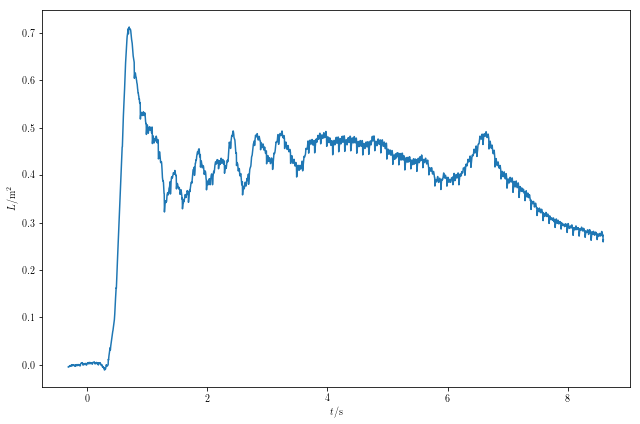

In [12]:
plt.figure(figsize=(9, 6))
plt.plot(t, L)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'$L/\mathrm{m^2}$');

## Optional Functionality


### `select`: Compute $L$ for a selection

 To improve the signal to noise ratio, $L$ can be computed from a subset of the frame. That selection is the same for all frames in the sequence.   
The format is `((vertical start, vertical end), (horizontal start, horizontal end))`

Frame([[ 74,  85, 101, ...,  64,  82,  66],
       [ 66,  77,  94, ...,  70,  79,  83],
       [ 82,  92,  87, ...,  71,  70,  71],
       ...,
       [118,  85,  90, ..., 102, 102,  86],
       [117,  78,  79, ..., 127, 139, 122],
       [ 94,  67,  88, ...,  71,  78,  72]], dtype=uint8)
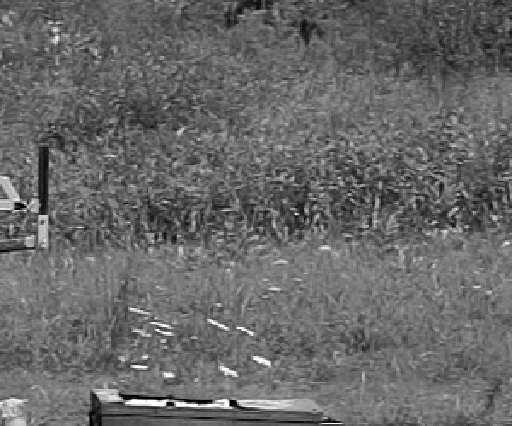

In [13]:
sel = ((0, 250), (140, 440))

seq[0][0:250, 140:440]

Per pixel values stay unchanges. Cumulative values ($B_{melt}, B_0$) have to be re-computed.

In [14]:
H1, W1 = 250, 300
Bmelt1 = H1 * W1 * bmelt
Sc1 = H1 * W1 * res ** 2
Sc1

1.172255273120606

The functions of the `luminance` module have a `select` switch, where appropriate, which use the above format.

In [15]:
B01 = luminance.average_cbright(seq[:94], select=sel)
L1 = luminance.luminance_sequence(seq, Sc1, Bmelt1, B01, select=sel)

/home/ingo/.local/opt/pyens/sp3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


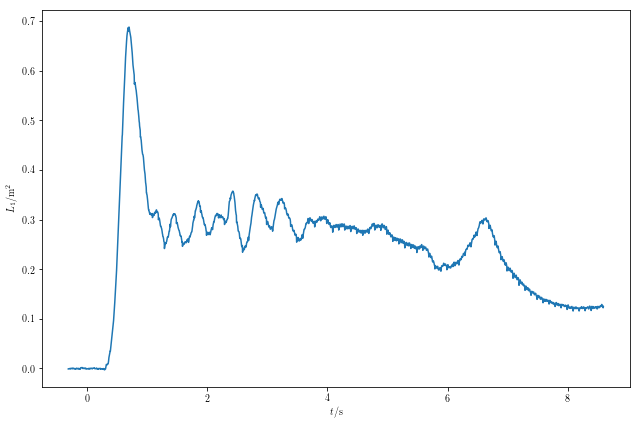

In [18]:
plt.figure(figsize=(9, 6))
plt.plot(t, L1)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'$L_1/\mathrm{m^2}$');

### Propagation of Uncertainties / Measurement Errors

Image resolutions $a$ (```res``` in the code)
$$
a = \frac{x}{X}\quad,
$$
where $x$ is a known length in real space, measured for example in meters, and $X$ is the same length on the camera's chip, measured in px. In this example the container width is known to be $x=0.51\,\mathrm{m}$ wide, and the accuracy is about $\pm2\,\mathrm{mm}$. In the image sequence the container width is $X=129\,\mathrm{px}$, and the accuracy there is about $\pm1\,\mathrm{px}$.

$$
\sigma_{a}^2 = a^2\,\Bigl(\frac{\sigma_x^2}{x^2} + \frac{\sigma_X^2}{X^2}\Bigr)
$$

In [24]:
σres = res * np.sqrt((2e-3 / 0.51) ** 2 + (1 / 129.1) ** 2)
res, σres

(0.003950426026336174, 3.429784003160414e-05)

The camera specific melt brightness of one pixel is ${b_{melt}=175}{}$ (no units here). Playing around with a suitable averaging area shows that this value typically changes by about ${\sigma_{b_{melt}}=\pm5}$. 
$$
\sigma_{B_{melt}} = \sigma_{b_{melt}}\frac{B_{melt}}{b_{melt}}
$$

In [28]:
σbmelt = 5.
σBmelt = σbmelt * Bmelt / bmelt
σBmelt

983040.0

Error of $S_c$:

$$
\sigma_{S_c} = 2S_c\,\frac{\sigma_{a}}{a}
$$

In [29]:
σSc = 2 * Sc * σres / res
σSc

0.05335989289659072

Uncertainty for the background level (noise) $B_0$ comes from the temporal changes during the averaging period (here during the first 94 frames of the image sequence. The `average_cbright()` function has an `uncert` switch. When set to `True` a tuple of $B_0$ and its standard deviation is returned.

In [32]:
B0, σB0 = luminance.average_cbright(chunk=seq[:94], uncert=True)
B0, σB0

(21031168.617021278, 8966.795410760395)

Luminances uncertainty is evaluated as:
$$
\sigma_L^2 = \biggl(\frac{L}{B_{melt}-B_0}\biggr)^2 \sigma_{B_{melt}}^2 +
\biggl(\frac{L - 1}{B_{melt}-B_0}\biggr)^2\sigma_{B_0}^2 +
\biggl(\frac{L}{S_c}\biggr)^2\sigma_{S_c}^2
\quad,
$$
and is available as function `sigma_luminance()`, that returns an array with uncertainties for each frame it was given in the `lum` parameter.

In [35]:
σL = luminance.sigma_luminance(lum=L, ref=Bmelt, sref=σBmelt, noise=B0, snoise=σB0,
                               fov=Sc, sfov=σSc)

A plot with the standard deviation as gray shadow:

/home/ingo/.local/opt/pyens/sp3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


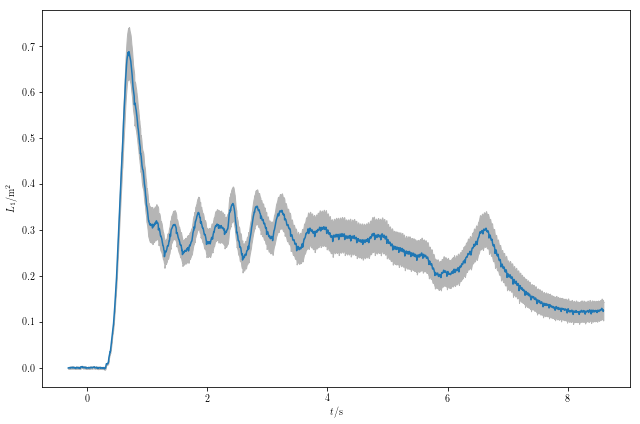

In [40]:
plt.figure(figsize=(9, 6))
plt.fill_between(t, L1 + σL, L1 - σL, color='#b5b5b5')
plt.plot(t, L1)
plt.xlabel(r'$t/\mathrm{s}$')
plt.ylabel(r'$L_1/\mathrm{m^2}$');